1. Loading and preparing data...

2. Aggregating data by week...

5. Training GRU model...
Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - loss: 0.7291 - val_loss: 0.4373 - learning_rate: 0.0010
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3272 - val_loss: 0.0713 - learning_rate: 0.0010
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0434 - val_loss: 0.0458 - learning_rate: 0.0010
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0734 - val_loss: 0.0756 - learning_rate: 0.0010
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0700 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0062 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0197 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0267 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms

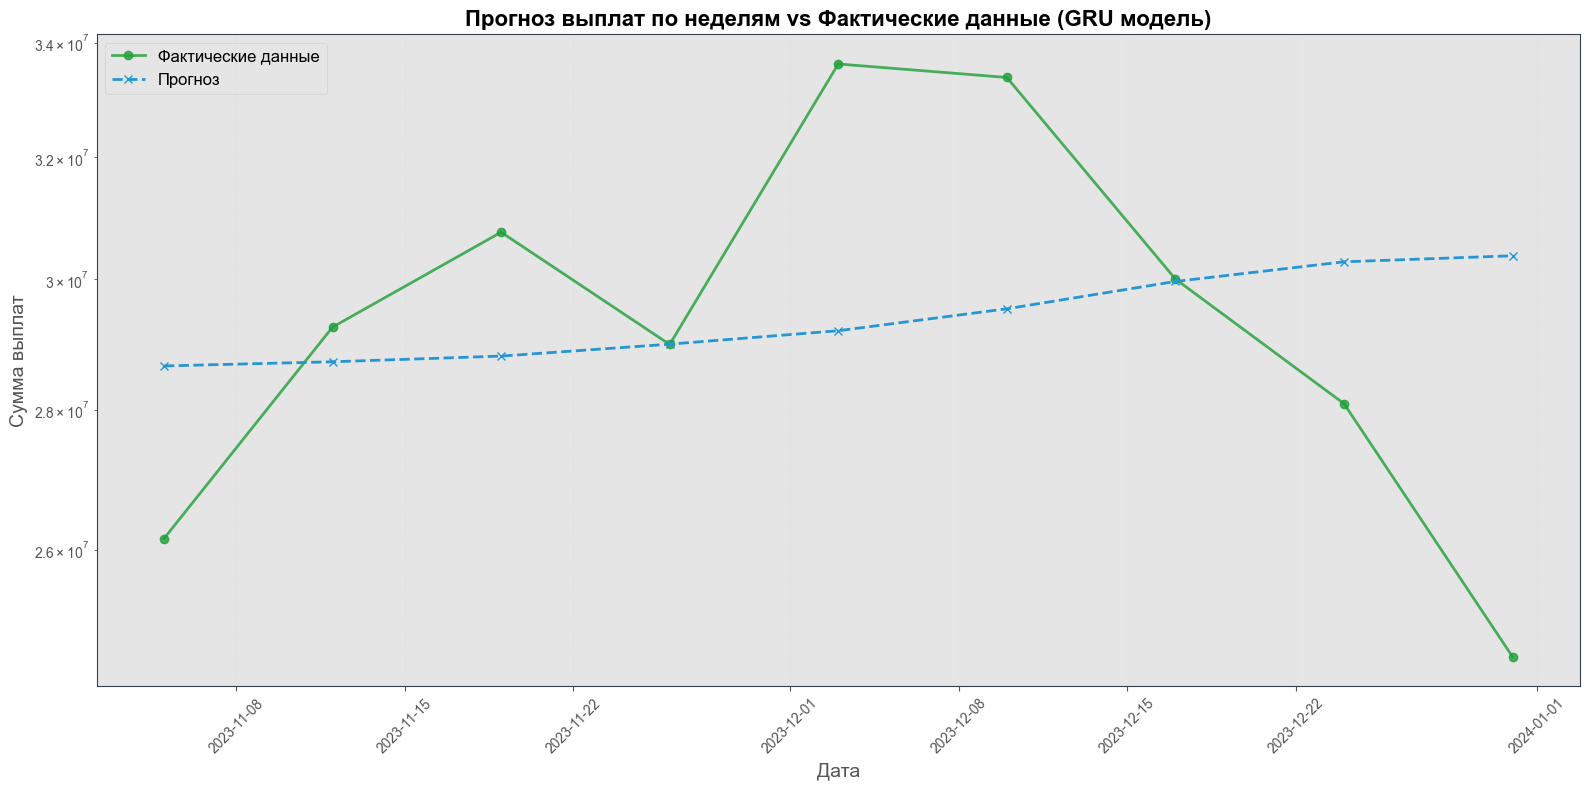


Метрики теста GRU модели:
MAE: 2366284.85
MSE: 9250303775261.55
RMSE: 3041431.21
MAPE: 8.22%

Генерация прогноза на 1 год (52 недели)...
Сгенерирован прогноз для 12/52 недель
Сгенерирован прогноз для 24/52 недель
Сгенерирован прогноз для 36/52 недель
Сгенерирован прогноз для 48/52 недель


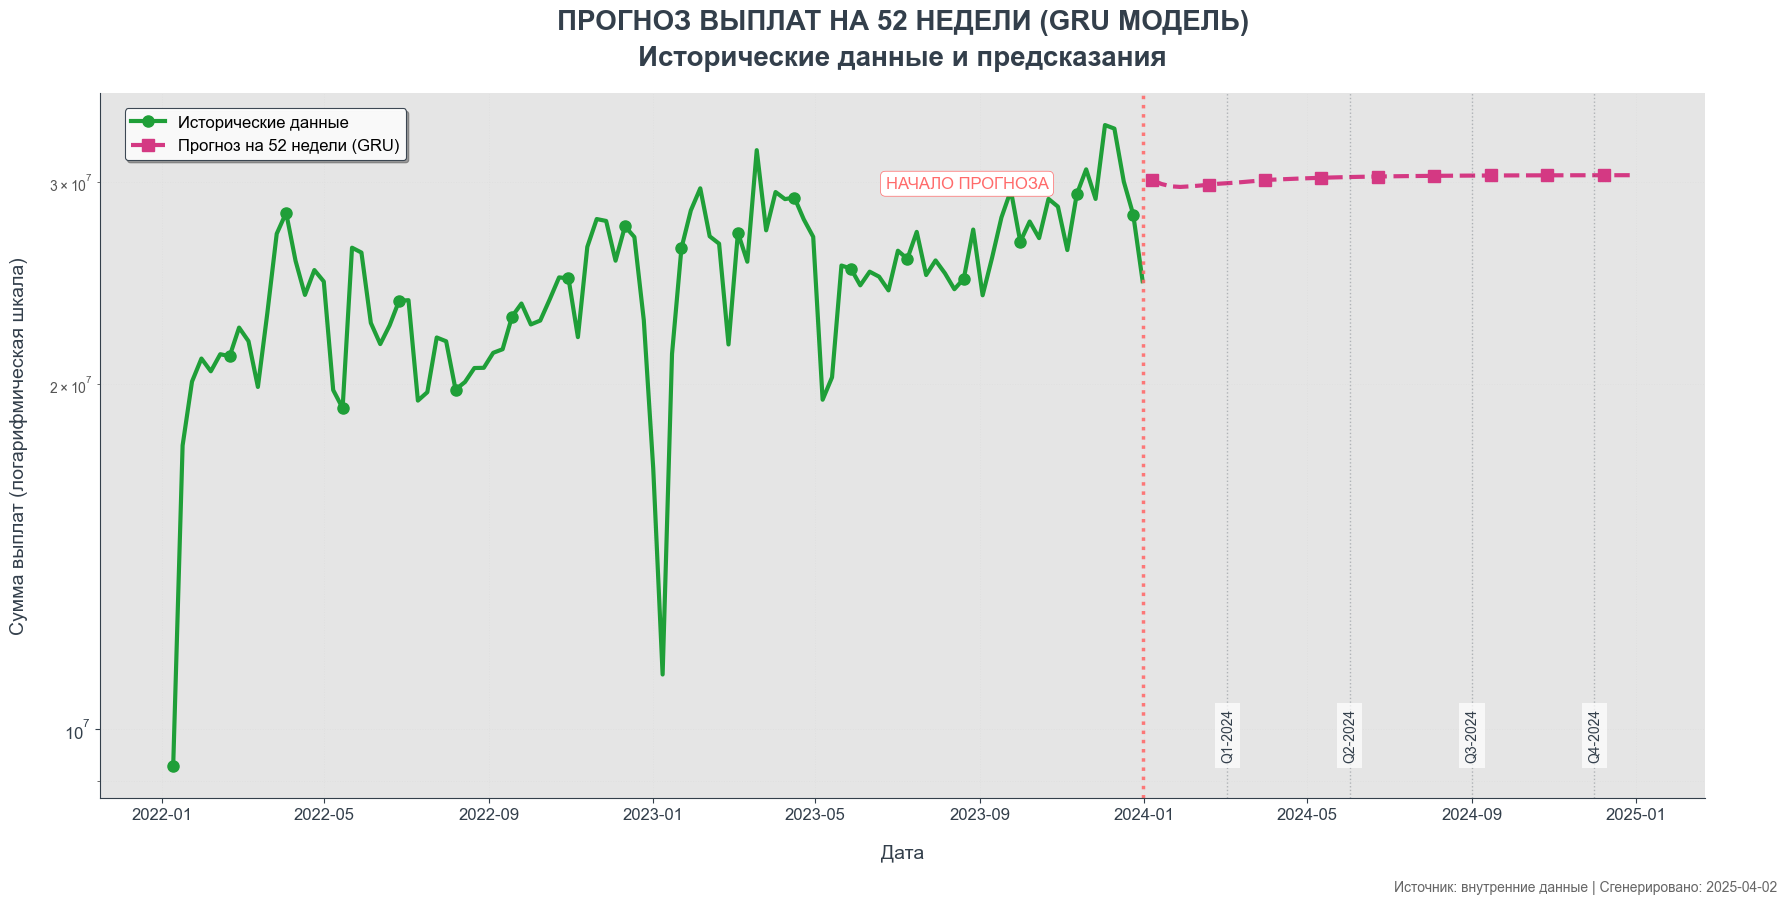


Quarterly Forecast Summary (GRU model):
                      sum        mean            std
year quarter                                        
2024 Q1       388622784.0  29894060.0  144878.397229
     Q2       393214496.0  30247268.0   64403.983899
     Q3       394754304.0  30365716.0   15942.806269
     Q4       395130848.0  30394680.0    3885.354968

Detailed 52-week GRU forecast saved to 'gru_52week_forecast.csv'


In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Load and prepare data
print("1. Loading and preparing data...")
data = pd.read_csv(r"D:\repositories\cup_it_25\CupIT_Sber_data.csv", delimiter=";", decimal=',')

data['service_amount_net'] = pd.to_numeric(data['service_amount_net'], errors='coerce')
data['service_date'] = pd.to_datetime(data['service_date'])
data = data.dropna(subset=['service_date', 'service_amount_net'])

# 2. Aggregate by WEEK and apply log transform
print("\n2. Aggregating data by week...")
weekly_data = data.resample('W', on='service_date')['service_amount_net'].sum().to_frame('total_payments')
weekly_data = weekly_data[weekly_data['total_payments'] > 0]
weekly_data['log_payments'] = np.log(weekly_data['total_payments'])

# 3. Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
weekly_data['scaled_payments'] = scaler.fit_transform(weekly_data[['log_payments']])

# 4. Prepare data for GRU
def create_sequences(data, seq_length=12):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

# Using 12 weeks (about 3 months) as sequence length
seq_length = 12
train_size = int(len(weekly_data) * 0.8)
train_data = weekly_data.iloc[:train_size]['scaled_payments'].values
test_data = weekly_data.iloc[train_size:]['scaled_payments'].values

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 5. Build and train GRU model (enhanced for longer forecasts)
print("\n5. Training GRU model...")
model = Sequential([
    GRU(128, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Add early stopping and learning rate reduction
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 6. Make predictions
print("\n6. Making predictions...")
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Визуализация результатов
plt.figure(figsize=(16, 8))

# Фактические данные
plt.plot(weekly_data.index[train_size+seq_length:], np.exp(actual), 
         label='Фактические данные', color='#1F9F38', marker='o', markersize=6, alpha=0.8, linewidth=2)

# Предсказанные данные
plt.plot(weekly_data.index[train_size+seq_length:], np.exp(predictions), 
         label='Прогноз', color='#2496D4', linestyle='--', marker='x', markersize=6, linewidth=2)

plt.title('Прогноз выплат по неделям vs Фактические данные (GRU модель)', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Сумма выплат', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=45)
plt.yscale('log')
plt.tight_layout()
plt.show()

# 8. Вычисление метрик
mae = mean_absolute_error(np.exp(actual), np.exp(predictions))
mse = mean_squared_error(np.exp(actual), np.exp(predictions))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.exp(actual) - np.exp(predictions)) / np.exp(actual))) * 100

print("\nМетрики теста GRU модели:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# 9. Прогноз на 1 год (52 недели)
print("\nГенерация прогноза на 1 год (52 недели)...")
future_steps = 52
future_predictions = []
current_input = test_data[-seq_length:].tolist()

for i in range(future_steps):
    input_seq = np.array(current_input[-seq_length:]).reshape(1, seq_length, 1)
    next_pred = model.predict(input_seq, verbose=0)[0, 0]
    future_predictions.append(next_pred)
    current_input.append(next_pred)
    if (i+1) % 12 == 0:
        print(f"Сгенерирован прогноз для {i+1}/{future_steps} недель")

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 10. Профессиональная визуализация прогноза
plt.figure(figsize=(18, 9), facecolor='white')

# Настраиваем стиль
available_styles = plt.style.available
if 'seaborn' in available_styles:
    plt.style.use('seaborn')
else:
    plt.style.use('ggplot')

# Основные параметры оформления
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.edgecolor'] = '#333F4B'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['grid.color'] = '#DDDDDD'
plt.rcParams['grid.alpha'] = 0.5

# Исторические данные (последние 2 года)
history_dates = weekly_data.index[-104:]
history_values = np.exp(weekly_data['log_payments'].values[-104:])

# Прогнозные данные
forecast_dates = pd.date_range(start=weekly_data.index[-1] + pd.Timedelta(weeks=1), 
                              periods=future_steps, freq='W')
forecast_values = np.exp(future_predictions).flatten()

# 1. Основной график с историей и прогнозом
main_plot = plt.plot(history_dates, history_values, 
                    label='Исторические данные', 
                    color='#1F9F38', linewidth=3, 
                    marker='o', markersize=8, markevery=6)

forecast_plot = plt.plot(forecast_dates, forecast_values, 
                        label='Прогноз на 52 недели (GRU)', 
                        color='#D43983', linewidth=3,  # Изменен цвет для отличия от LSTM
                        linestyle='--', marker='s', markersize=8, markevery=6)

# 2. Яркая граница между историей и прогнозом
boundary_line = plt.axvline(x=history_dates[-1], color='#FF6B6B', linestyle=':', linewidth=2.5, alpha=0.9)
plt.text(history_dates[-1] - pd.Timedelta(weeks=10), plt.ylim()[1]*0.85, 
         'НАЧАЛО ПРОГНОЗА', fontsize=12, color='#FF6B6B', ha='right', 
         bbox=dict(facecolor='white', edgecolor='#FF6B6B', boxstyle='round,pad=0.3'))

# 3. Квартальные разделители с подписями
for qdate in forecast_dates[(forecast_dates.month % 3 == 0) & (forecast_dates.day < 7)]:
    plt.axvline(x=qdate, color='#333F4B', linestyle=':', linewidth=1, alpha=0.3)
    quarter_label = f"Q{qdate.quarter}-{qdate.year}"
    plt.text(qdate, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.05, quarter_label, 
             fontsize=10, color='#333F4B', ha='center', rotation=90, 
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# 4. Заголовок и подписи осей
plt.title('ПРОГНОЗ ВЫПЛАТ НА 52 НЕДЕЛИ (GRU МОДЕЛЬ)\nИсторические данные и предсказания', 
          fontsize=20, fontweight='bold', pad=20, color='#333F4B', linespacing=1.5)
plt.xlabel('Дата', fontsize=14, labelpad=15, color='#333F4B')
plt.ylabel('Сумма выплат (логарифмическая шкала)', fontsize=14, labelpad=15, color='#333F4B')

# 5. Легенда с тенью
legend = plt.legend(frameon=True, fontsize=12, loc='upper left',
                   facecolor='white', edgecolor='#333F4B', shadow=True,
                   bbox_to_anchor=(0.01, 0.99), framealpha=0.95)
legend.get_frame().set_linewidth(0.8)

# 6. Логарифмическая шкала с улучшенной сеткой
plt.yscale('log')
plt.grid(True, which="both", ls=":", linewidth=0.7, alpha=0.6)

# 7. Настройка осей
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, colors='#333F4B')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('#333F4B')

# 8. Подпись источника и даты создания
plt.text(0.99, 0.01, f'Источник: внутренние данные | Сгенерировано: {pd.Timestamp.now().strftime("%Y-%m-%d")}', 
         transform=plt.gcf().transFigure, 
         ha='right', va='bottom', color='#666666', fontsize=10)

# 9. Автоматическое выравнивание и отступы
plt.tight_layout()
plt.subplots_adjust(top=0.9, right=0.95)

plt.show()

# 11. Save detailed forecast
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'forecast_amount': np.exp(future_predictions).flatten(),
    'log_forecast': future_predictions.flatten()
})

# Add month and quarter information
forecast_df['month'] = forecast_df['date'].dt.month_name()
forecast_df['quarter'] = 'Q' + forecast_df['date'].dt.quarter.astype(str)
forecast_df['year'] = forecast_df['date'].dt.year

# Calculate quarterly aggregates
quarterly_forecast = forecast_df.groupby(['year', 'quarter'])['forecast_amount'].agg(['sum', 'mean', 'std'])
print("\nQuarterly Forecast Summary (GRU model):")
print(quarterly_forecast)

forecast_df.to_csv('gru_52week_forecast.csv', index=False)
print("\nDetailed 52-week GRU forecast saved to 'gru_52week_forecast.csv'")


Метрики теста GRU модели:
MAE: 2366284.85
MSE: 9250303775261.55
RMSE: 3041431.21
MAPE: 8.22%

Тест Льюнга-Бокса для остатков GRU модели:
     lb_stat  lb_pvalue
1   1.522767   0.217201
2   1.575260   0.454922
3   2.772785   0.428000
4   6.231739   0.182497
5   6.903017   0.227954
6   7.627385   0.266692
7   7.679955   0.361659
8  10.808187   0.212806

Значение p-value: 0.2128

Вывод: p-value > 0.05 → Нет оснований отвергать нулевую гипотезу.
Остатки модели не демонстрируют значимой автокорреляции, что свидетельствует
об адекватности модели и хорошем учете временной структуры данных.


<Figure size 1200x500 with 0 Axes>

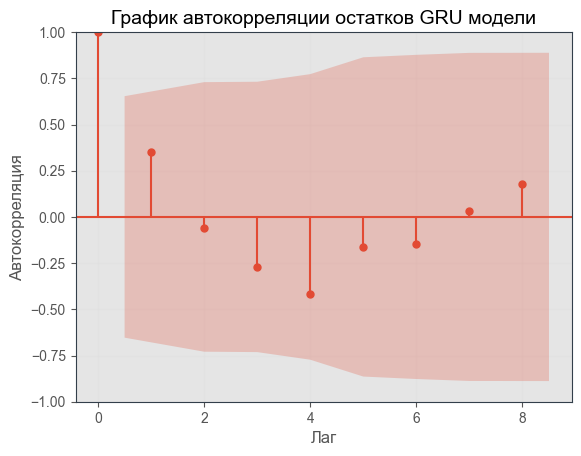

In [4]:
# 8. Вычисление метрик
mae = mean_absolute_error(np.exp(actual), np.exp(predictions))
mse = mean_squared_error(np.exp(actual), np.exp(predictions))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.exp(actual) - np.exp(predictions)) / np.exp(actual))) * 100

print("\nМетрики теста GRU модели:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# 8.1. Тест Льюнга-Бокса для анализа автокорреляции остатков
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

# Получение остатков модели
residuals = np.exp(actual).flatten() - np.exp(predictions).flatten()

# Автоматический подбор максимального количества лагов
max_possible_lags = min(10, len(residuals) - 1)  # Не больше 10 и не больше len(residuals)-1

# Тест Льюнга-Бокса
if max_possible_lags > 0:
    print("\nТест Льюнга-Бокса для остатков GRU модели:")
    lb_test = acorr_ljungbox(residuals, lags=max_possible_lags, return_df=True)
    print(lb_test)
    
    # Анализ p-value
    p_value = lb_test['lb_pvalue'].iloc[-1]
    print(f"\nЗначение p-value: {p_value:.4f}")
    
    # Интерпретация результатов
    if p_value > 0.05:
        print("\nВывод: p-value > 0.05 → Нет оснований отвергать нулевую гипотезу.")
        print("Остатки модели не демонстрируют значимой автокорреляции, что свидетельствует")
        print("об адекватности модели и хорошем учете временной структуры данных.")
    else:
        print("\nВывод: p-value ≤ 0.05 → Отвергаем нулевую гипотезу.")
        print("Остатки содержат значимую автокорреляцию, что указывает на:")
        print("- Неучтенные временные зависимости в данных")
        print("- Возможное несоответствие архитектуры GRU модели")
        print("- Необходимость дополнительной настройки гиперпараметров")
        print("- Возможность добавления сезонных компонент или дополнительных признаков")
        
    # Визуализация автокорреляции остатков
    plt.figure(figsize=(12, 5))
    plot_acf(residuals, lags=max_possible_lags, alpha=0.05)
    plt.title('График автокорреляции остатков GRU модели', fontsize=14)
    plt.xlabel('Лаг', fontsize=12)
    plt.ylabel('Автокорреляция', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("\nНедостаточно данных для выполнения теста Льюнга-Бокса (требуется минимум 2 наблюдения).")